In [78]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.patches import Patch
from pathlib import Path
# from sklearn.metrics import ConfusionMatrixDisplay

from ba_dev.utils import load_path_yaml
from ba_dev.eval_helpers import *

paths = load_path_yaml('/cfs/earth/scratch/kraftjul/BA/data/path_config.yml')

set_custom_plot_style()
cm = 1 / 2.54

export = False

In [69]:
# calculating the balanced accuracy score for all runs
# bal_acc = evaluate_all_runs(
#     path_to_runs=paths['complete_models'],
#     metrics='balanced_accuracy_score',
#     )

# bal_acc.to_csv('bal_acc.csv', index=False)

bal_acc = pd.read_csv('bal_acc.csv')

In [ ]:
# generating the balanced accuracy table

table = (
    bal_acc
    .groupby(['model_name', 'pretrained'])
    .agg(
        trainable_params=('trainable_params', 'first'),
        img_score_mean=('img_score', 'mean'),
        img_score_std =('img_score', 'std'),
        seq_score_mean=('seq_score', 'mean'),
        seq_score_std =('seq_score', 'std'),
    )
    .reset_index()
    .sort_values(by='img_score_mean', ascending=False)
    ).rename(columns={
    'model_name': 'Model',
    'pretrained': 'Pretrained',
    'trainable_params': 'Params (M)',
    'img_score_mean': r'$\mu_{\mathrm{img}}$',
    'img_score_std': r'$\sigma_{\mathrm{img}}$',
    'seq_score_mean': r'$\mu_{\mathrm{seq}}$',
    'seq_score_std': r'$\sigma_{\mathrm{seq}}$',
})

table['Pretrained'] = table['Pretrained'].map({True: 'Yes', False: 'No'})
table['Params (M)'] = (table['Params (M)'] / 1_000_000).astype(int)
table['Model'] = table['Model'].str.replace('_', r'\_')

float_fmt = lambda x: f"{x:.4f}"

latex = table.to_latex(
    index=False,
    column_format='l c r c c c c',
    float_format=float_fmt,
    escape=False,
    caption=r'Balanced accuracy of all models across all folds at the image and sequence levels, sorted by $\mu_{\mathrm{img}}$.',
    label='tab:bal_acc'
    )

latex = latex.replace(r'\begin{table}', r'\begin{table}[H]', 1)

if export:
    with open(paths['table'] / 'bal_acc_by_model.tex', 'w') as f:
        f.write(latex)

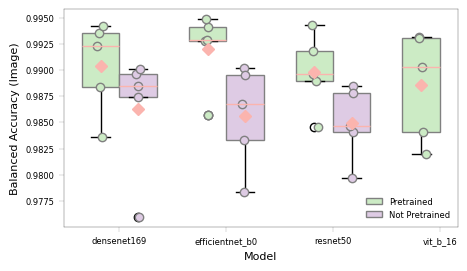

In [97]:
# Box Plot for Balanced Accuracy by Model and Pretrained Status
########################################################################################################################
fig_name = 'bal_acc_img.pdf'
fig_size = (12*cm,7*cm)
########################################################################################################################

models = sorted(bal_acc['model_name'].unique())
n = len(models)
x = range(n)
width = 0.35

# collect your two series
data_pre = [
    bal_acc[(bal_acc['model_name']==m) & (bal_acc['pretrained'])]['img_score'] 
    for m in models
]
data_no = [
    bal_acc[(bal_acc['model_name']==m) & (~bal_acc['pretrained'])]['img_score'] 
    for m in models
]

cmap = plt.get_cmap('Pastel1')
color_pre = cmap(2)
color_no  = cmap(3)
red = cmap(0)

plt.figure(figsize=fig_size)

medianprops = dict(linewidth=1, color=red)

meanprops = dict(
    marker='D',
    markeredgecolor=red,
    markerfacecolor=red,
    markersize=6
)

# draw the boxplots
bp_pre = plt.boxplot(
    data_pre,
    positions=[i - width/2 for i in x],
    widths=width,
    patch_artist=True,
    manage_ticks=False,
    showmeans=True,
    meanprops=meanprops,
    medianprops=medianprops
)
bp_no = plt.boxplot(
    data_no,
    positions=[i + width/2 for i in x],
    widths=width,
    patch_artist=True,
    manage_ticks=False,
    showmeans=True,
    meanprops=meanprops,
    medianprops=medianprops
)

# apply facecolors and a subtle edge
for box in bp_pre['boxes']:
    box.set_facecolor(color_pre)
    box.set_edgecolor('gray')
for box in bp_no['boxes']:
    box.set_facecolor(color_no)
    box.set_edgecolor('gray')

# axes labels
plt.xticks(x, models, ha='center')
plt.xlabel('Model')
plt.ylabel('Balanced Accuracy (Image)')

# legend with box patches!
legend_handles = [
    Patch(facecolor=color_pre, edgecolor='gray', label='Pretrained'),
    Patch(facecolor=color_no,  edgecolor='gray', label='Not Pretrained')
]
plt.legend(handles=legend_handles, frameon=False, loc='lower right')

for i, m in enumerate(models):
    # pretrained points
    y_pre = bal_acc[(bal_acc['model_name']==m) & (bal_acc['pretrained'])]['img_score']
    x_pre = np.random.normal(i - width/2, width*0.05, size=len(y_pre))
    plt.scatter(x_pre, y_pre, color=color_pre, edgecolor='gray', zorder=2)

    # non-pretrained points
    y_no  = bal_acc[(bal_acc['model_name']==m) & (~bal_acc['pretrained'])]['img_score']
    x_no  = np.random.normal(i + width/2, width*0.05, size=len(y_no))
    plt.scatter(x_no, y_no, color=color_no,  edgecolor='gray', zorder=2)


plt.tight_layout()
if export:
    plt.savefig(paths['figures'] / fig_name, dpi=300)
plt.show()